# Resampling



## 0.환경준비

### 0.1 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 0.2 데이터 로딩

> 예제 데이터는 반도체 공정간 불량을 예측하는 데이터입니다.  
여기서는 class imbalance 에 대한 샘플링과 성능에만 초점을 맞추겠습니다.


In [2]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition2.csv"
data = pd.read_csv(path)

## 1.데이터 탐색


* 데이터의 크기를 살펴봅시다.

In [3]:
data.shape

(1150, 17)

In [4]:
data.head()

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1


In [5]:
target = 'Attrition'

0    1050
1     100
Name: Attrition, dtype: int64


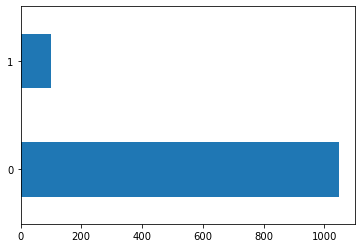

In [6]:
print(data[target].value_counts())

data[target].value_counts().plot(kind = 'barh')
plt.show()

## 2.데이터 준비


### 2.1 x, y로 나누기 

In [7]:
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2.2 가변수화

In [8]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','JobSatisfaction','MaritalStatus',
              'RelationshipSatisfaction','WorkLifeBalance'] # 가변수화 대상 변수 이름 리스트 만든다
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True) 

### 2.3 train : validation 분할

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state = 2022)

In [11]:
x_train.shape

(805, 38)

## 3.모델링 with Resampling

In [12]:
# 필요한 라이브러리, 함수들을 불러옵시다.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

### 3.1 기본 모델링

* 로지스틱 회귀 + 데이터 그대로 이용

In [13]:
model = LogisticRegression()
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[323   0]
 [ 22   0]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       323
           1       0.00      0.00      0.00        22

    accuracy                           0.94       345
   macro avg       0.47      0.50      0.48       345
weighted avg       0.88      0.94      0.91       345



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

LogisticRegression : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
* 이전 버전 solver = 'liblinear'
* 최근 버전 solver = 'lbfgs' (max_iter 옵션 경고 문구들이 발생)

In [14]:
model = LogisticRegression(solver = 'liblinear')
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[321   2]
 [ 20   2]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       323
           1       0.50      0.09      0.15        22

    accuracy                           0.94       345
   macro avg       0.72      0.54      0.56       345
weighted avg       0.91      0.94      0.92       345



### 3.2 모델링 with Resampling

* Down Sampling + 로지스틱 회귀
    * Resamlpling
    * 모델링
    * 평가 : confusion_matrix, classification_report

In [15]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [16]:
# down sampling
down_sample = RandomUnderSampler()
d_x_train, d_y_train = down_sample.fit_resample(x_train, y_train)

print(np.bincount(d_y_train))
print(np.bincount(d_y_train) / d_y_train.shape[0])

model_d = LogisticRegression(solver = 'liblinear')
model_d.fit(d_x_train, d_y_train)
pred_d = model_d.predict(x_val)

print(f1_score(y_val,pred_d, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_d))
print('-' * 55)
print(classification_report(y_val, pred_d))

[78 78]
[0.5 0.5]
0.2857142857142857
-------------------------------------------------------
[[225  98]
 [  2  20]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       323
           1       0.17      0.91      0.29        22

    accuracy                           0.71       345
   macro avg       0.58      0.80      0.55       345
weighted avg       0.94      0.71      0.78       345



* Up Sampling + 로지스틱 회귀
    * Resamlpling
    * 모델링
    * 평가 : confusion_matrix, classification_report

In [17]:
# up sampling
up_sample = RandomOverSampler()
u_x_train, u_y_train = up_sample.fit_resample(x_train, y_train)

print(np.bincount(u_y_train))
print(np.bincount(u_y_train) / u_y_train.shape[0])

model_u = LogisticRegression(solver = 'liblinear')
model_u.fit(u_x_train, u_y_train)
pred_u = model_u.predict(x_val)

print(f1_score(y_val,pred_u, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_u))
print('-' * 55)
print(classification_report(y_val, pred_u))

[727 727]
[0.5 0.5]
0.28125
-------------------------------------------------------
[[235  88]
 [  4  18]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       323
           1       0.17      0.82      0.28        22

    accuracy                           0.73       345
   macro avg       0.58      0.77      0.56       345
weighted avg       0.93      0.73      0.80       345



* SMOTE Sampling + 로지스틱 회귀
    * Resamlpling
    * 모델링
    * 평가 : confusion_matrix, classification_report

In [18]:
# SMOTE
smote = SMOTE()
s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

print(np.bincount(s_y_train))
print(np.bincount(s_y_train) / s_y_train.shape[0])

model_s = LogisticRegression(solver = 'liblinear')
model_s.fit(s_x_train, s_y_train)
pred_s = model_u.predict(x_val)

print(f1_score(y_val,pred_s, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_s))
print('-' * 55)
print(classification_report(y_val, pred_s))

[727 727]
[0.5 0.5]
0.28125
-------------------------------------------------------
[[235  88]
 [  4  18]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       323
           1       0.17      0.82      0.28        22

    accuracy                           0.73       345
   macro avg       0.58      0.77      0.56       345
weighted avg       0.93      0.73      0.80       345



### 3.3 각 resampling 기법별로 성능을 비교해 봅시다.
여러번 반복실행한 다음 f1 score 성능 비교


In [19]:
def lr_modeling(x_train, y_train, x_val, y_val) :
    m = LogisticRegression(solver = 'liblinear')
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    return f1_score(y_val,pred, pos_label=1)

In [20]:
result_d, result_u, result_s = [], [], []

for i in range(50):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .4)
    d_x_train, d_y_train = down_sample.fit_resample(x_train, y_train)
    u_x_train, u_y_train = up_sample.fit_resample(x_train, y_train)
    s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

    result_d.append(lr_modeling(d_x_train, d_y_train, x_val, y_val))
    result_u.append(lr_modeling(u_x_train, u_y_train, x_val, y_val))
    result_s.append(lr_modeling(s_x_train, s_y_train, x_val, y_val))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


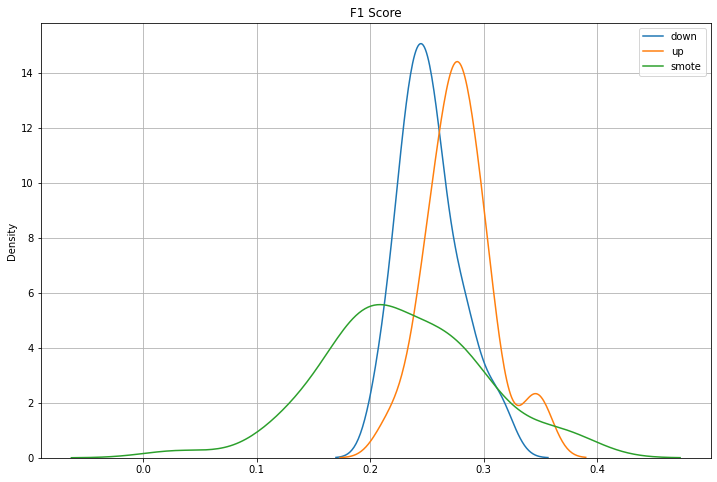

In [21]:
# 그래프로 비교
plt.figure(figsize=(12, 8))
sns.kdeplot(result_d, label = 'down')
sns.kdeplot(result_u, label = 'up')
sns.kdeplot(result_s, label = 'smote' )

plt.title('F1 Score')
plt.legend()
plt.grid()
plt.show()


## 4.실습 : Semiconductor manufacturing process dataset


![](https://assets.pandaily.com/uploads/2021/10/semiconductor.png)

* 반도체 제조 공정은 시점별로 수많은 센서로부터 정보를 수집하여 공정을 감시합니다. 
* 센서정보와 함께 공정간 발생된 불량품에 대한 정보를 저장하였습니다.
* 불량을 예측해 봅시다.

### 4.1 데이터 준비

* 데이터 로딩

In [22]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)
data.head()

,v021,v087,v088,v089,v114,v115,v116,v117,v118,v120,...,v528,v571,v572,v573,v574,v575,v576,v577,v578,label
0,1.4026,2.3895,0.9690,1747.6049,0.9460,0.0,748.6115,0.9908,58.4306,0.9804,...,6.6926,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0
1,1.3825,2.3754,0.9894,1931.6464,0.9425,0.0,731.2517,0.9902,58.6680,0.9731,...,8.8370,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0
2,1.4123,2.4532,0.9880,1685.8514,0.9231,0.0,718.5777,0.9899,58.4808,0.9772,...,6.4568,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,1
3,1.4011,2.4004,0.9904,1752.0968,0.9564,0.0,709.0867,0.9906,58.6635,0.9761,...,6.4865,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0
4,1.3888,2.4530,0.9902,1828.3846,0.9424,0.0,796.5950,0.9908,58.3858,0.9628,...,6.3745,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0


변수 정보 
* label : 1 - 불량, 0 - 정상
* v### : 센서값들


In [23]:
target = 'label'

In [24]:
data[target].value_counts() / data.shape[0]

0    0.933631
1    0.066369
Name: label, dtype: float64

* x, y로 나누기 

In [25]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 가변수화 Dummy Variable  
모두 숫자 데이터이므로 가변수화 대상은 없습니다.


* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2022)

In [28]:
print(x_train.shape, x_val.shape)

(1253, 52) (314, 52)


### 4.2 기본모델링
> * 알고리즘은 로지스틱 회귀를 이용합시다.
* 데이터셋을 그대로 모델링을 수행하시오.
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import * 

In [30]:
model = LogisticRegression(solver = 'liblinear')
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[295   1]
 [ 18   0]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       296
           1       0.00      0.00      0.00        18

    accuracy                           0.94       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.89      0.94      0.91       314



### 4.3 모델링 with Resampling
> * down, up, smote 샘플링후 각각 데이터를 이용하여 모델링 하시오.
* 알고리즘 : 기존 샘플과 비교를 위해서 기본모델링에 사용한 알고리즘 사용
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [31]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [32]:
# down sampling
down_sample = RandomUnderSampler()
d_x_train, d_y_train = down_sample.fit_resample(x_train, y_train)

print(np.bincount(d_y_train))
print(np.bincount(d_y_train) / d_y_train.shape[0])

[86 86]
[0.5 0.5]


In [33]:
# up sampling
up_sample = RandomOverSampler()
u_x_train, u_y_train = up_sample.fit_resample(x_train, y_train)

print(np.bincount(u_y_train))
print(np.bincount(u_y_train) / u_y_train.shape[0])


[1167 1167]
[0.5 0.5]


In [34]:
# SMOTE
smote = SMOTE()
s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

print(np.bincount(s_y_train))
print(np.bincount(s_y_train) / s_y_train.shape[0])

[1167 1167]
[0.5 0.5]


* 모델링

In [35]:
model_d = LogisticRegression(solver = 'liblinear')
model_d.fit(d_x_train, d_y_train)
pred_d = model_d.predict(x_val)

print(f1_score(y_val,pred_d, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_d))
print('-' * 55)
print(classification_report(y_val, pred_d))

0.13496932515337423
-------------------------------------------------------
[[162 134]
 [  7  11]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.55      0.70       296
           1       0.08      0.61      0.13        18

    accuracy                           0.55       314
   macro avg       0.52      0.58      0.42       314
weighted avg       0.91      0.55      0.66       314



In [36]:
model_d = LogisticRegression(solver = 'liblinear')
model_d.fit(u_x_train, u_y_train)
pred_d = model_d.predict(x_val)

print(f1_score(y_val,pred_d, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_d))
print('-' * 55)
print(classification_report(y_val, pred_d))

0.13513513513513514
-------------------------------------------------------
[[176 120]
 [  8  10]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       296
           1       0.08      0.56      0.14        18

    accuracy                           0.59       314
   macro avg       0.52      0.58      0.43       314
weighted avg       0.91      0.59      0.70       314



In [37]:
model_d = LogisticRegression(solver = 'liblinear')
model_d.fit(d_x_train, d_y_train)
pred_d = model_d.predict(x_val)

print(f1_score(y_val,pred_d, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_d))
print('-' * 55)
print(classification_report(y_val, pred_d))

0.13496932515337423
-------------------------------------------------------
[[162 134]
 [  7  11]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.55      0.70       296
           1       0.08      0.61      0.13        18

    accuracy                           0.55       314
   macro avg       0.52      0.58      0.42       314
weighted avg       0.91      0.55      0.66       314



* 로지스틱 회귀- 여러번 반복 실행

3.3의 코드를 붙여놓고 실행해 봅시다.

In [38]:
def lr_modeling(x_train, y_train, x_val, y_val) :
    m = LogisticRegression(solver = 'liblinear')
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    return f1_score(y_val,pred, pos_label=1)

In [39]:
result_d, result_u, result_s = [], [], []

for i in range(50):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .4)
    d_x_train, d_y_train = down_sample.fit_resample(x_train, y_train)
    u_x_train, u_y_train = up_sample.fit_resample(x_train, y_train)
    s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

    result_d.append(lr_modeling(d_x_train, d_y_train, x_val, y_val))
    result_u.append(lr_modeling(u_x_train, u_y_train, x_val, y_val))
    result_s.append(lr_modeling(s_x_train, s_y_train, x_val, y_val))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


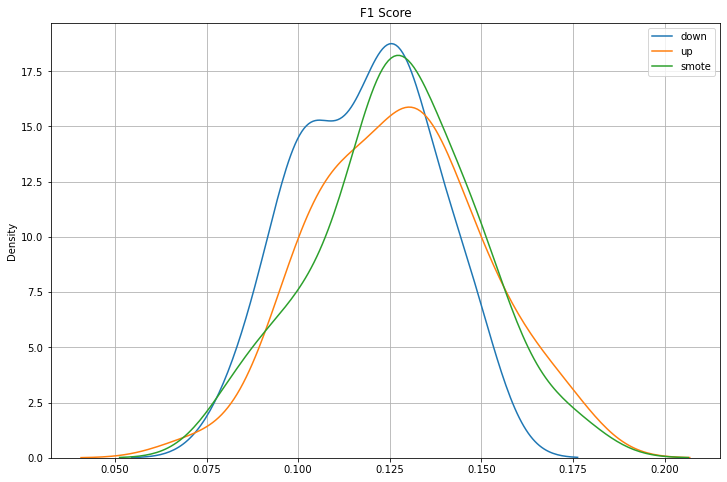

In [40]:
# 그래프로 비교
plt.figure(figsize=(12, 8))
sns.kdeplot(result_d, label= 'down')
sns.kdeplot(result_u, label = 'up')
sns.kdeplot(result_s, label = 'smote' )

plt.title('F1 Score')
plt.legend()
plt.grid()
plt.show()
